## Statistics Review with Jelly (Weeks 1 & 2)

### Topics Covered 
* Probability 
* Bayes' Theorem 
* CDF 
* Welch t-test (sometimes Welch's)
* ANOVA 
* Confidence Intervals 

### Data 
Student Performance on Exams from [Kaggle](https://www.kaggle.com/datasets/whenamancodes/students-performance-in-exams/data) :) 

In [14]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt, seaborn as sns


In [15]:
#Step 0 -- Read in Data 

df = pd.read_csv("/Users/jellyspratley/Documents/Marcy/DA_Lectures_Instructors/Mod4/StatsReview/exams.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


### EDA and Data Cleaning ALWAYS happens :) 

In [16]:
# Step 1 -- Feature Engineering/A Lil' Cleaning 

df.columns = (
    df.columns.str.lower()
      .str.replace(r"[^a-z0-9]+","_", regex=True)
      .str.strip("_")
)

#Create an overall score that adds all the scores together 
df["overall_score"] = df[["math_score","reading_score","writing_score"]].mean(axis=1)

#Create a passed variable that is binary 
PASS_CUT = 70
df["passed"] = (df["overall_score"] >= PASS_CUT)

#Lowercase the 'completion' level within the test_preparation_course variable
df["prep_completed"] = (df["test_preparation_course"].str.lower() == "completed")

df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,overall_score,passed,prep_completed
0,male,group A,high school,standard,completed,67,67,63,65.666667,False,True
1,female,group D,some high school,free/reduced,none,40,59,55,51.333333,False,False
2,male,group E,some college,free/reduced,none,59,60,50,56.333333,False,False
3,male,group B,high school,standard,none,77,78,68,74.333333,True,False
4,male,group E,associate's degree,standard,completed,78,73,68,73.000000,True,True


### Probability Rules you'll actually use 
Complement: if 72% pass, then 28% don’t (you’ll use this constantly when interpreting metrics).

Addition/Multiplication: when to add vs multiply; independence warning.

**From data: compute P(pass), P(prep), P(pass ∩ prep), P(pass | prep).**

In [17]:
# Step 2 -- Probability/A Lil' Bayes

#Function to get means of our boolean values 
def p(s): return s.mean()

#Probability of students who passed 
p_pass = p(df["passed"])
#Probability of students who completed prep
p_prep = p(df["prep_completed"])
#Probability of students who passed AND completed prep
p_pass_and_prep = p(df["passed"] & df["prep_completed"])
#Probability of NOT passing 
p_not_pass = 1 - p_pass
#Probability a student will pass given they have prepped 
p_pass_given_prep = p_pass_and_prep / p_prep

print(f"P(pass) = {p_pass:.3f}")
print(f"P(prep) = {p_prep:.3f}")
print(f"P(pass ∩ prep) = {p_pass_and_prep:.3f}")
print(f"P(pass | prep) = {p_pass_given_prep:.3f}")
print(f"P(not pass) = {p_not_pass:.3f}")

P(pass) = 0.447
P(prep) = 0.335
P(pass ∩ prep) = 0.195
P(pass | prep) = 0.582
P(not pass) = 0.553


### Bayes' theorem = updated belief after evidence 

Your prior = baseline pass rate; evidence = who completed prep; posterior = P(pass | prep).

Compare both the (direct conditional from data) and the Bayes calculation below (prior, sensitivity, false-positive) -- should get the same answer! 

In [18]:
#Step 3 -- More Bayes

#Given our historical data, what is the probability a student passes if they completed the prep course

# Prior Prob:  What we know from the data 
prior = p_pass
tpr  = p(df.loc[df["passed"], "prep_completed"])   # P(prep|pass)
fpr   = p(df.loc[~df["passed"], "prep_completed"])  # P(prep|not pass)

def bayes_posterior(prior, p_B_given_A, p_B_given_notA):
    return (p_B_given_A*prior) / (p_B_given_A*prior + p_B_given_notA*(1-prior))
posterior_pass_given_prep = bayes_posterior(prior, tpr, fpr)

print(f"Bayes posterior P(pass | prep) = {posterior_pass_given_prep:.3f}")
#Check against the answer you got in the previous cell 
print(f"Direct conditional check = {p_pass_given_prep:.3f}")

Bayes posterior P(pass | prep) = 0.582
Direct conditional check = 0.582


### PDF vs CDF: how to read AND use them with data 

PDF (hist density) tells you the shape and “where values live.”

CDF tells you P(X ≤ x)—the probability up to a threshold (e.g., “% of students scoring ≤ 80”).

Subtract the CDF from 1 to get the probability of a student having a score greater than 80

In [19]:
# 4) PDF vs CDF (math_score)
x = df["math_score"].astype(float)
BINS = 15
hist_vals, bin_edges = np.histogram(x, bins=BINS, density=True)
#Get the probability of a math score of 80
TARGET = 80
cdf_at_target = (x <= TARGET).mean()

print(f"CDF at {TARGET} (P(X ≤ {TARGET})) = {cdf_at_target:.3f}")
#PDF (hist density) ≈ “relative likelihood around x”, CDF = P(X ≤ x)

CDF at 80 (P(X ≤ 80)) = 0.812


### Welch's t-test: Most common two-sample comparison in the real world

Question: “Did prep help math scores?” → compare prep_completed vs not.

Why Welch: you rarely know/assume equal variances in the "wild"

In [20]:
# 5) Welch's t-test (difference in mean math score for prepping vs no prep)
alpha = 0.05
a = df.loc[df["prep_completed"], "math_score"].astype(float)
b = df.loc[~df["prep_completed"], "math_score"].astype(float)
tt = stats.ttest_ind(a, b, equal_var=False)
print(f"t = {tt.statistic:.3f}, p = {tt.pvalue:.4f}, reject H0 @ {alpha}? {tt.pvalue < alpha}")
print(f"Group means: completed={a.mean():.1f}, none={b.mean():.1f}")

t = 4.851, p = 0.0000, reject H0 @ 0.05? True
Group means: completed=69.7, none=64.7


### One-way ANOVA for 3+ groups 

Use a categorical segment (e.g., “race_ethnicity” in the file, or swap to “cohort/region” in your product data) to test “at least one mean differs.”

- H0: All group means are the same
- HA: A sig difference in the mean does exist in **at least one group**

In [21]:
# 6) Is the mean math score different across all levels of race_ethnicity
groups = [g["math_score"].astype(float).values for _, g in df.groupby("race_ethnicity")]
anova = stats.f_oneway(*groups)
print(f"ANOVA F = {anova.statistic:.3f}, p = {anova.pvalue:.4f}, reject H0? {anova.pvalue < alpha}")

ANOVA F = 18.466, p = 0.0000, reject H0? True


### Confidence Intervals you'll report all the time

Mean CI (t-based): center ± t*SE for math_score.

Proportion CI (Wilson): for passed. This is the CI you’ll use when reporting conversion rates.
    - "We're ~95% confident the true pop conversion rate is between LL and UL" 

In [22]:
# 7) Confidence Intervals --  

alpha = 0.05  # or reuse your existing alpha

# Define x here so the cell is standalone
x = pd.to_numeric(df["math_score"], errors="coerce").dropna()

n = x.size
xbar = x.mean()
s = x.std(ddof=1)
se = s / np.sqrt(n)
tcrit = stats.t.ppf(1 - alpha/2, df=n - 1)
mean_ci = (xbar - tcrit*se, xbar + tcrit*se)
print(f"Mean(math) = {xbar:.2f} ; {int((1-alpha)*100)}% CI = ({mean_ci[0]:.2f}, {mean_ci[1]:.2f})")


# Proportion CI for 'passed'

valid = df["passed"].notna()
clicks = df.loc[valid, "passed"].sum()
nobs = valid.sum()
prop_ci = proportion_confint(count=clicks, nobs=nobs, alpha=alpha, method="wilson")
print(f"Prop(pass) = {clicks/nobs:.3f} ; {int((1-alpha)*100)}% Wilson CI = ({prop_ci[0]:.3f}, {prop_ci[1]:.3f})")

Mean(math) = 66.40 ; 95% CI = (65.44, 67.35)
Prop(pass) = 0.447 ; 95% Wilson CI = (0.416, 0.478)


### Bayes' Theorem Steps (simulating DataCamp) -- ADVANCED 

- Filters the subgroup: uses only rows where prep_completed == True and looks at passed (Boolean) to model the true pass rate for this subgroup.

- Splits into two batches: picks counts k1/n1 and k2/n2 to simulate “first study” then “follow-up study.”

- Builds a parameter grid: creates a fine grid of θ values from 0.001 to 0.999 representing possible true pass rates.

- Computes likelihoods: for each θ, evaluates the Binomial likelihood 

- Forms the old posterior: multiplies a uniform prior by Batch-1 likelihood and normalizes so the density integrates to 1.

- Updates to the new posterior: uses the old posterior as the new prior, multiplies by Batch-2 likelihood, and normalizes again.

- Summarizes beliefs: reports MAP (peak), posterior mean, and the 95% credible interval from the cumulative density.

- Plots both posteriors: draws old posterior (becomes the new prior) and new posterior so you can visually compare the **shift (updated belief) and width (uncertainty).**

### Bayes' Theorem Key Terms:

- pass_rate_grid: a list of possible true pass rates (0% to 100%). We test each candidate and see how plausible it is given the data.

- prior (before data): our starting belief about the pass rate. We use a flat prior to start neutral.

- likelihood: “If the true pass rate were r, how likely is it to see k passes out of n?” (Binomial formula).

- posterior (after data): updated belief = prior × likelihood, then normalize so the curve sums to 1 (we divide by the total area using a simple sum).

- old → new: the old posterior (after batch 1) becomes the new prior for batch 2, then we update again to get the new posterior.

- MAP: the pass rate where the posterior is highest (the peak of the curve).

- Posterior mean: the average of the whole curve (a smoothed estimate).

- 95% credible interval: the middle 95% of our belief mass. “Given the data and our prior, we think the true pass rate is in this range 95% of the time.”

Batch1: 3/10  |  Batch2: 7/12
Old posterior (after batch1): MAP=0.300, mean=0.333, 95% CI=[0.109, 0.609]
New posterior (after batch2): MAP=0.455, mean=0.458, 95% CI=[0.268, 0.655]


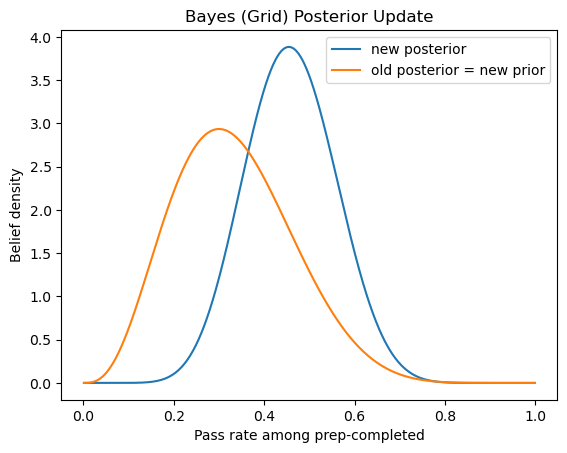

In [25]:
# 1) Choose two batches from the prep-completed subgroup
n1, n2 = 10, 12
g = df.loc[df["prep_completed"], "passed"].dropna().sample(frac=1, random_state=42)
k1 = int(g.iloc[:n1].sum())                  # successes in batch 1
k2 = int(g.iloc[n1:n1+n2].sum())             # successes in batch 2
print(f"Batch1: {k1}/{n1}  |  Batch2: {k2}/{n2}")

# 2) Build a grid of possible pass rates we want to consider (0%..100%)
pass_rate_grid = np.linspace(0.001, 0.999, 1000)
step = pass_rate_grid[1] - pass_rate_grid[0]  # spacing between grid points

# 3) Function to update beliefs: prior × likelihood -> posterior, then normalize
def update_posterior(prior_density, successes, trials):
    # Binomial likelihood: "How likely is what we saw if the true pass rate was r?"
    r = pass_rate_grid
    likelihood = (r ** successes) * ((1 - r) ** (trials - successes))
    unnormalized = prior_density * likelihood
    area = unnormalized.sum() * step          # simple area under the curve
    return unnormalized / area                # make it sum to 1 over the grid

# Start with a flat (uniform) prior: we don't favor any pass rate at the start
# All passing probs are equally likely (10%, 20%, 30% etc)
prior_flat = np.ones_like(pass_rate_grid)

# Old posterior (after Batch 1), then use it as the new prior for Batch 2
posterior_old = update_posterior(prior_flat, k1, n1)          # after batch 1
posterior_new = update_posterior(posterior_old, k2, n2)       # after batch 2

# 4) Quick summaries: peak (MAP), average (mean), and 95% credible interval
def summarize(density):
    r = pass_rate_grid
    map_est = r[np.argmax(density)]                           # most likely pass rate
    mean_est = (r * density).sum() * step                     # average of the curve
    cdf = np.cumsum(density) * step                           # running total (0..1)
    lo = r[np.searchsorted(cdf, 0.025)]
    hi = r[np.searchsorted(cdf, 0.975)]
    return map_est, mean_est, (lo, hi)

m1, mean1, ci1 = summarize(posterior_old)
m2, mean2, ci2 = summarize(posterior_new)

print(f"Old posterior (after batch1): MAP={m1:.3f}, mean={mean1:.3f}, 95% CI=[{ci1[0]:.3f}, {ci1[1]:.3f}]")
print(f"New posterior (after batch2): MAP={m2:.3f}, mean={mean2:.3f}, 95% CI=[{ci2[0]:.3f}, {ci2[1]:.3f}]")

# 5) DataFrames for seaborn (keyword args to avoid the positional-args error)
df_old = pd.DataFrame({"efficacy_rate": pass_rate_grid, "posterior_prob": posterior_old})
df_new = pd.DataFrame({"efficacy_rate": pass_rate_grid, "new_posterior_prob": posterior_new})

sns.lineplot(data=df_new, x="efficacy_rate", y="new_posterior_prob", label="new posterior")
sns.lineplot(data=df_old, x="efficacy_rate", y="posterior_prob", label="old posterior = new prior")
plt.xlabel("Pass rate among prep-completed"); plt.ylabel("Belief density"); plt.title("Bayes (Grid) Posterior Update")
plt.legend(); plt.show()